# Lab 7: K-Means Clustering 🗂

## Learning Objectives
* Calculate distance between points using Euclidean and Manhattan method
* Understand k-means clustering algorithm
* Visualize clusters
* Understand how to find appropriate k value from sum of squared errors

## Today's Lab

Today we will be taking our first look at clustering as a machine learning topic — specifically, [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering). K-means is an [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning) method, which means that it doesn't need to have "true" labels or examples to learn a pattern. Instead, this class of algorithms can be described as pattern recognizers in the truest sense.

In this lab, we will first try our hand at implementing the algorithm, during which we will investigate how it works and explore some of the caveats to know when you use it. Then we will end by discussion how to choose the right number of clusters for your data.

By the end of the lab, you should have a pretty decent understanding of how $k$-means works.

## Outline

1. [Getting Started](#1.-Getting-Started)
    1. [What is Clustering?](#What-is-Clustering?)
    2. [Loading-Our-Toy-Data](#Loading-Our-Toy-Data)
2. [Implementing K-means](#2.-Implementing-K-means)
    1. [Initializing Our Centroids](#Initializing-Our-Centroids)
    2. [Similarity Measures](#Similarity-Measures)
    3. [Assigning Points to Clusters](#Assigning-Points-to-Clusters)
    4. [Updating Centroids](#Updating-Centroids)
    5. [Putting Things Together](#Putting-Things-Together)
3. [Does the Distance Measure Matter?](#3.-Does-the-Distance-Measure-Matter?)
4. [\[Optional\] K-means On A Not-So-Simple Dataset](#4.-\[Optional\]-K\-means-On-A-Not\-So\-Simple-Dataset)

## 1. Getting Started

### What is Clustering?

As usual, I'm just going to have Wikipedia do the honors of explaining what clustering is. Here is a quote from [Cluster Analysis](https://en.wikipedia.org/wiki/Cluster_analysis):

> Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters).

A common theme in our discussion of machine learning so far is the fact that we try to build models of the world that can describe specific phenomena. We want to be able to extract the patterns encoded by our observations (data) to study how a process works and potentially predict how that process might work in the future. In the case of $k$-means, we seek to systematically extract information about the distribution of our data by answering questions like "do our observations naturally form groups?"

![clustering](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Cluster-2.svg/220px-Cluster-2.svg.png)

Clustering, and especially $k$-means, is not just another algorithm, but can actually be a useful addition to any EDA process.

### Loading Our Toy Data

As usual, we will use some toy data to help us with our implementation. First, let's load the packages we will use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from utility.util_lab import configure_plots

configure_plots()

To help facilitate this process we have provided some toy data for you to use. In the cell we import the `load_toy` function, into which we can pass the number of points we would like to have $N$ and the number of clusters we would like to have $k$, among other values. This function will then return data points $X$ and another value that we don't really need to worry about now.

> **For the interested:** Feel free to check out how this data is generated.

In [8]:
from utility.util_lab import load_toy

n, k = 300, 3
X, _ = load_toy(n, k, random_state=17)

Let's take a look at what we get.

**Try this!** In the cell below, produce a scatterplot of the data $X$. As a review, also be sure to add proper plot components.

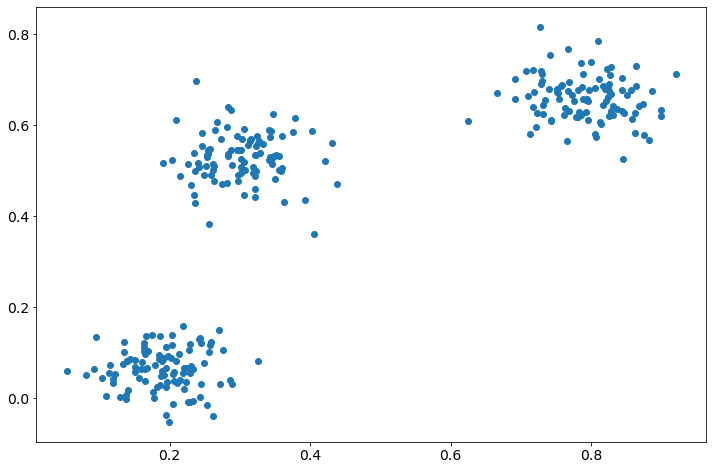

In [7]:
# your code here 
plt.scatter(X[:,0], X[:,1])

## 2. Implementing K-means

### Initializing Our Centroids

But wait what are centroids? In the $k$-means terminology, centroids are the centers of our clusters and will be what we use to determine to which cluster some point $x$ belongs.

While there are many ways to initialize our centroids, a _not-too-bad_ way to go about it is to randomly sample them from from our data. Later on, we will take a look at what you'll need to be aware of when choosing these points.

**Try this!** Complete the `sample_centroids` function so that it randomly samples and returns $k$ points from $X$ that we can use as our initial centroids. To make things easy, please return the centroids as a NumPy array with a structure similar to the $X$ matrix. 
> **Hint**: You can choose/sample from an array using [`np.random.choice` 🔗](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html).

In [15]:
def sample_centroids(X, k, random_state=None):
    '''Sample and return K data points from X'''
    
    if random_state:
        np.random.seed(random_state)
    else:
        np.random.seed(int(time.time()))
    
    centroids = X[np.random.choice(np.arange(X.shape[0]),k), :]
    
    assert isinstance(centroids, np.ndarray), 'Your centroids should be in a NumPy array'
    assert centroids.shape == (k, X.shape[1]), f'Your centroids should have shape ({k}, {X.shape[1]})'
    
    return centroids

In [16]:
centroids = sample_centroids(X, k, random_state=9)

Let's take a peek at which points where chosen.

**Try this!** In the cell below, add the centroids to the scatter plot of $X$ you made earlier. Make sure that the centroids are obviously visible. 
> **Hint**: Consider changing the size `s`, symbol `marker`, and color `c` of the centroid points.

Text(0, 0.5, 'x2')

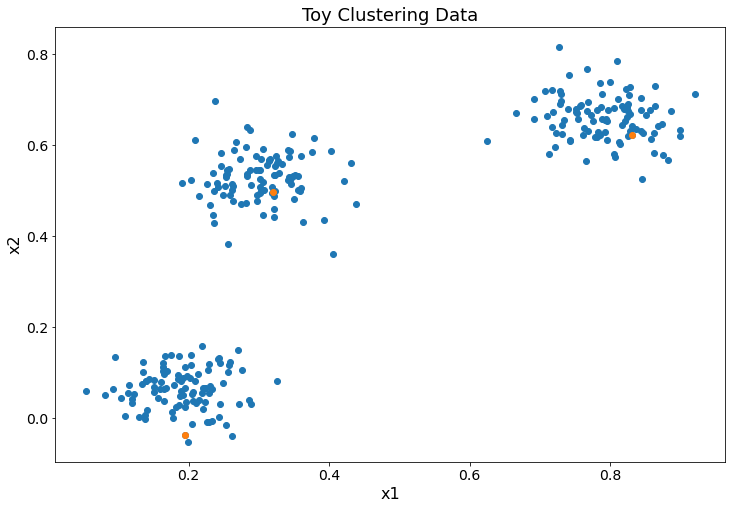

In [17]:
plt.scatter(X[:, 0], X[:, 1])

plt.scatter(centroids[:, 0], centroids[:, 1])

plt.title('Toy Clustering Data')
plt.xlabel('x1')
plt.ylabel('x2')

### Similarity Measures

Now that we have centroids, the next thing will want to do is to be able to compute the similarity (or distances) between a group of points to a centroid. In this section, we will implement [Euclidean](https://en.wikipedia.org/wiki/Euclidean_distance) and [Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) distances.

#### Euclidean Distance

I'm sure you are all familiar with this distance measure from life. Here is the formula for your reference: $$d(\vec{p}, \vec{q}) = \| \vec{p} - \vec{q} \| = \sqrt{\sum_{j=1}^{d} (p_j - q_j)^2}$$

**Try this!** Complete the `euclidean(a,b)` function so that it computes the [Euclidean](https://en.wikipedia.org/wiki/Euclidean_distance) distance between 
* one point `a` and point `b`, or 
* multiple points `a` and point `b` 

depending on the shape of `a`. In the first case return a _scalar_, in the second case return a _vector_ with one distance entry per row of `a`.
    
> **Hint**: To find out if `a` is a vector (one point) or a matrix encoding several points, use the [`ndim` 🔗](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.ndim.html) of a NumPy array to find its dimensionality. Then use `numpy` functions with the appropriate arguments to compute the distance(s) in either case. Avoid using any `for` loops. 

In [30]:
def euclidean(a, b):
    '''Computes the Euclidean distance between point(s) a and another point b'''
    
    # both a and b need to have the same number of feature dimensions (columns)
    assert a.shape[1] == b.shape[0] if a.ndim > 1 else a.shape[0] == b.shape[0], \
        'number of columns in a and b need to be the same'
    
    
    if a.ndim == 1:
        distance = np.sqrt(np.sum(np.square(a-b)))
    else:
        distance = np.sqrt(np.sum(np.square(a-b),axis=1))

    
    assert isinstance(distance, (float, np.float64, np.ndarray)), 'distance should be a float or a NumPy array'
    
    assert a.ndim==1 if not isinstance(distance, np.ndarray) else distance.shape[0] == a.shape[0], \
        'distance should have the same number of distances as points in A'
    
    return distance

Let's see if your computation was right. Work out the Euclidean distance between $(0, 0)$ and $(2, 2)$ and compare that value to what your function returns.

In [31]:
# TEST distance between one point and another point
a = np.zeros(2)
b = np.array([2, 2])

euclidean(a,b)

2.8284271247461903

In [32]:
# TEST distance between three points and another point
a = np.zeros([3, 2])
b = np.array([2, 2])

euclidean(a,b)

array([2.82842712, 2.82842712, 2.82842712])

#### Manhattan Distance

Here's an example of an alternative distance measure. Imagine that you are actually trying to drive between two places in a city like New York.

![manhattan](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Manhattan_distance.svg/200px-Manhattan_distance.svg.png)

How far do you have to go?

Here is the formula: 
$$d(\vec{p}, \vec{q}) = \sum_{j=1}^{d} |p_j - q_j|$$


**Try this!** Complete the `manhattan(a,b)` function so that it computes the [Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) distance between 
* one point `a` and point `b`, or 
* multiple points `a` and point `b` 

depending on the shape of `a`. In the first case return a _scalar_, in the second case return a _vector_ with one distance entry per row of `a`.

> **Hint:** Again, follow the same approach as for the `eucliden` function and use `numpy` functions to compute the distance measure(s) rather than `for` loops. Copy your code from the `euclidean` function and simply update the formula.  

In [39]:
def manhattan(a, b):
    '''Computes the Manhattan distance between point(s) A and another point B'''

    # both a and b need to have the same number of feature dimensions (columns)
    assert a.shape[1] == b.shape[0] if a.ndim > 1 else a.shape[0] == b.shape[0], \
        'number of columns in a and b need to be the same'
    
    if a.ndim == 1:
        distance = np.sum(np.abs(a-b))
    else:
        distance = np.sum(np.abs(a-b), axis=1)

    
    assert isinstance(distance, (float, np.float64, np.ndarray)), 'distance should be a float or a NumPy array'
        
    assert a.ndim==1 if not isinstance(distance, np.ndarray) else distance.shape[0] == a.shape[0], \
        'distance should have the same number of distances as points in a'
    
    return distance

Check with your neighbors that your implementation works.

In [40]:
# TEST distance between one point and another point
a = np.zeros(2)
b = np.array([2, 2])

manhattan(a,b)

4.0

In [41]:
# TEST distance between three points and another point
a = np.zeros([3, 2])
b = np.array([2, 2])

manhattan(a,b)

array([4., 4., 4.])

### Assigning Points to Clusters

Okay, we can now get back to what we wanted to do: cluster. In this section we will implement a function that can take a point $x$ or a matrix $X$ and assign it or them to the cluster of the closest centroid.

**Try this!** Complete the `assign` function so that it assigns each point to a cluster denoted by the index of the closest centroid. For example, if some point $x$ is closest to centroid $c_0$ then it should be assigned to cluster $0$. 
>**Hints**: One way to do this begins by creating an $n \times k$ array of zeros to store distance values from each oberservation in `x` to each centroid in `centroids`. Then, you may use a `for` loop to fill up this distances matrix. Whenever you need to loop over the values in an array (or a list) while also needing the index, use [`enumerate` 🔗](https://docs.python.org/3/library/functions.html#enumerate). It gives you **both**, the index and the array/list entry. Finally, you will need to find and us a suitable `numpy` function that returns the appropriate index. This last step can be done by avoiding a `for` loop. 

In [58]:
def assign(x, centroids, distance_measure):
    '''
    Computes the cluster assignments for X or each point
    in X given some centroids and a distance measure
    '''
    
    assignments = np.zeros((x.shape[0],centroids.shape[0]))
    
    for j, centroid in enumerate(centroids):
        assignments[:, j] = distance_measure(x, centroid)
        
    assignments = np.argmin(assignments, axis=1)
        

    
    assert np.all(assignments >= 0) and np.all(assignments < len(centroids)), \
        'Assignments should be indices of centroids'
    
    return assignments

In [59]:
assignments = assign(X, centroids, euclidean)

Now that we can compute the cluster assignments, let's plot and visualize them.

**Try this!** Recreate the same plot you made before with the data points and the centroids, but this time color the data points based on their assignments.

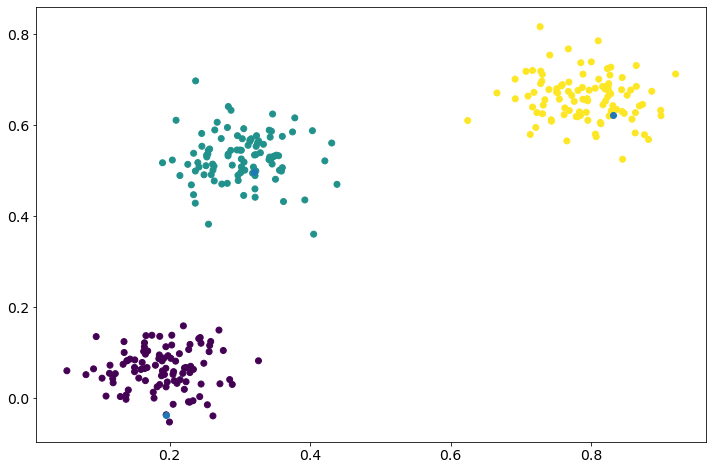

In [66]:
# your code here 
plt.scatter(X[:, 0], X[:, 1], c=assignments)
plt.scatter(centroids[:, 0], centroids[:, 1])

### Updating Centroids

Now that we have some plausible assignments of our data points into clusters centered on the centroids, we can think about how we might improve the centroids. In the $k$-means algorithm, we compute new centroids by averaging the positions of all data points assigned to a cluster. This average point describes a "central" location within each cluster and thus makes sense as a representative for each cluster.

**Try this!** Complete the `compute_centroids` function so that it computes a new centroid for each cluster given the points assigned to each cluster by averaging those points. 
>**Hint**: Consider using `np.unique` to find all possible assignment values. You then may loop over the clusters. 

In [102]:
def compute_centroids(X, assignments):
    '''Computes new centroids given points X and cluster ASSIGNMENTS'''
    
    clusters = np.unique(assignments)
    for cluster in clusters:
        centroids[cluster, :] = X[assignments == cluster].mean(axis=0)
    
    assert len(np.unique(assignments)) == len(centroids), \
        'You should have the same number of centroids as clusters'
    
    return centroids

Let's check that it works.

In [71]:
initial_centroids = centroids
centroids = compute_centroids(X, assignments)

With that, we have all of the components of the $k$-means algorithm. Let's look at a visualization of **one step** of the algorithm (_final_ should be thought of as _after one interation_). 

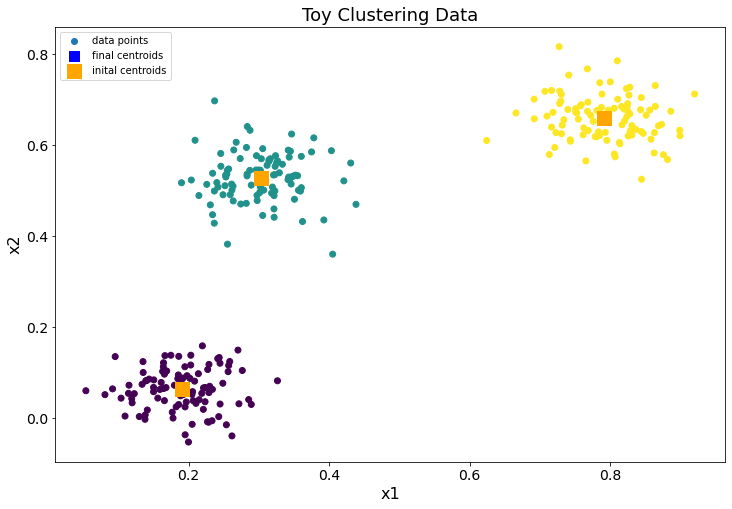

In [72]:
from utility.util_lab import plot_kmeans
plot_kmeans(X, centroids, prev_centroids=initial_centroids, assignments=assignments)

### Putting Things Together

With the last section, we finished all of the components that we need to construct the $k$-means algorithm. As you might have noticed, by repeating the assignment-cluster-mean cycle, we can get more and more central centroids. As we iterate

**Try this!** Complete the `fit` function, which should return the final centroids. Ensure that you make use of all of the supplied function arguments. If `initial` is `None` then you should generate some random centroids.

In [97]:
def fit(X, k, distance_measure, max_iters=1000, tol=1e-2, initial=None, random_state=None):
    '''
    Runs k-means cycle with data X and K clusters until either MAX_ITERS
    number of iterations have been performed or until the absolute centroid delta
    is less than TOL.
    '''
    
    if initial is None:
        centroids = sample_centroids(X, k, random_state=random_state)
    else:
        centroids = initial
    
    assert k == centroids.shape[0], \
        f'expected there to be {k} centroids but got {centroids.shape[0]}'
    
    iteration = 0
    while iteration < max_iters:
        prev, centroids = centroids, compute_centroids(X, assign(X,centroids,distance_measure))
        if prev.shape == centroids.shape:
            if np.all(np.abs(prev - centroids)) < tol:
                return centroids
        else:
            iteration = iteration + 1

    print("k-means convereged in %i iterations." % (iteration))       
    return centroids

Let's try it out. Execute the following cell a couple of times to see different random intializations. 

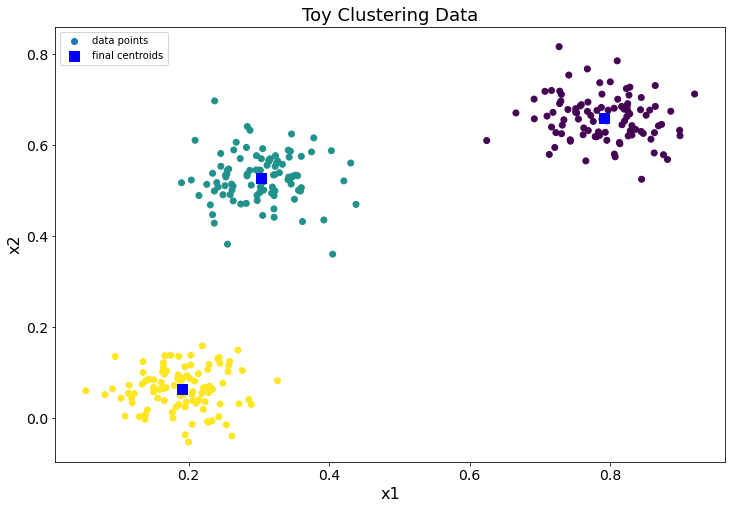

In [98]:
centroids = fit(X, k, euclidean)
assignments = assign(X, centroids, euclidean)

plot_kmeans(X, centroids, assignments=assignments)

## 2. Does the Distance Measure Matter?

Let's see if the different distance measures give differnt clustering results.

**Try this!** Now, use the **manhattan distance measure** in your clusterin algorithm and look at the outcome.

Text(0.5, 1.0, 'Toy Clustering using Manhattan')

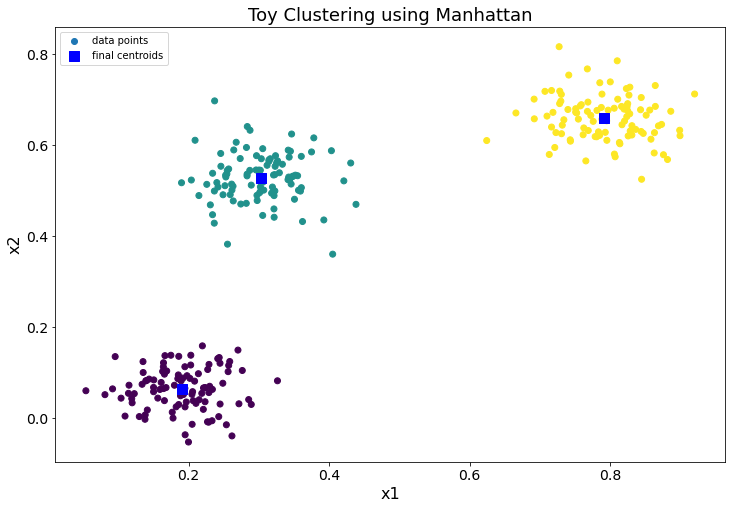

In [100]:
centroids = fit(X, k, manhattan)
assignments = assign(X, centroids, manhattan)


plot_kmeans(X, centroids, assignments=assignments)
plt.title("Toy Clustering using Manhattan")

Looks like the distance measure doesn't matter. Or maybe it does? Unfortunately, the experiment we made is not conclusive due to the randomness introduced by different intializations. So, let's do it again, but let's use a toy dataset with more clusters and make sure to use the same inital centroids for both runs. 

**Try this!** Plot the clustering you get using the given `initial_centroids` and `k=4` for both distance measures, `euclidean` and `manhattan`. 

In [105]:
n, k = 300, 4
X, _ = load_toy(n, k, random_state=17)
new_initial_centroids = sample_centroids(X, k, random_state=2)

manhattan_centroids = fit(X, k, manhattan)
manhattan_assignments = assign(X, new_initial_centroids, manhattan)

euclidian_centroids = fit(X, k, euclidian)
euclidian_assignments = assign(X, new_initial_centroids, euclidean)

plot_kmeans(X, euclidian_centroids, assignments=euclidian_assignments)
plot_kmeans(X, manhattan_centroids, assignments=manhattan_assignments)


IndexError: index 3 is out of bounds for axis 0 with size 3

**Write-up!**  Does the distance measure influence the final clusters? Describe both plots above and compare the resulting clusterings.

**Your response here:** 


## 3. [Optional] K-means On A Not-So-Simple Dataset

**Try this!** Let's try using $k$-means on a different dataset. In the cell below, we prepare $X$ for you. Cluster the data and visualize the results. Again execute the cell multiple times to see if the initialization matters.

In [ ]:
from sklearn.datasets import make_moons

X_moons, _ = make_moons(500, noise=0.1)

# your code here 


**Write-up!** What do you notice about the clustering results from $k$-means? What are the implications of these results? Write your answers below and discuss them with your neighbors.

**Your response here:** 
